# Atmospheric Equatorial Waves - Matsuno Model

This notebook demonstrates atmospheric equatorial wave dynamics using the Matsuno shallow water model.
Focused on convectively coupled equatorial waves (CCEWs) and tropical meteorology applications.

**Atmospheric Configuration:**
- Equivalent depth: 25-50 m (first baroclinic mode)
- Wave speeds: 15-22 m/s (typical for tropical convection)
- Time scales: Hours to days
- Amplitudes: 1-20 m (geopotential height perturbations)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
print("JAX device:", jax.devices())
import jax.numpy as jnp

from matsuno_shallow_water import create_matsuno_model, MatsunoConfig, MatsunoModel

# Enhanced plotting setup for atmospheric applications
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 12

Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

JAX device: [CpuDevice(id=0)]


W0000 00:00:1756496492.032130 45244596 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1756496492.043336 45244596 service.cc:145] XLA service 0x140073330 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756496492.043344 45244596 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1756496492.044494 45244596 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1756496492.044506 45244596 mps_client.cc:384] XLA backend will use up to 28990554112 bytes on device 0 for SimpleAllocator.


## 1. Atmospheric Model Configuration

Set up the model with parameters appropriate for atmospheric baroclinic modes.

In [2]:
# Create atmospheric model - first baroclinic mode
atm_model = create_matsuno_model(
    equivalent_depth=25.0,  # 25 m - typical for atmospheric convection
    dt_minutes=4.0,         # 4 minute time step for stability
    nt=720                  # 2 days simulation (48 hours)
)

print("=== ATMOSPHERIC EQUATORIAL WAVE MODEL ===")
print(f"Application: Convectively Coupled Equatorial Waves (CCEWs)")
print(f"Domain: {atm_model.config.lat_min}°S to {atm_model.config.lat_max}°N")
print(f"        {atm_model.config.lon_min}° to {atm_model.config.lon_max}°E")
print(f"Grid: {atm_model.config.nlat} × {atm_model.config.nlon} ({atm_model.dx/1000:.0f} km resolution)")

print(f"\n=== ATMOSPHERIC WAVE PARAMETERS ===")
print(f"Equivalent depth (H):        {atm_model.config.equivalent_depth} m")
print(f"Kelvin wave speed (c):       {atm_model.c:.1f} m/s ({atm_model.c*3.6:.0f} km/h)")
print(f"Deformation radius (L_eq):   {atm_model.L_eq/1000:.0f} km")
print(f"Beta parameter:              {atm_model.config.beta:.2e} m⁻¹s⁻¹")

print(f"\n=== TIME SCALES ===")
print(f"Time step:                   {atm_model.config.dt/60:.1f} minutes")
print(f"Simulation length:           {atm_model.config.nt * atm_model.config.dt/3600:.1f} hours")
print(f"Kelvin wave transit time:    {120*np.pi/180*atm_model.config.earth_radius/atm_model.c/3600:.1f} hours (across domain)")
print(f"CFL numbers: x={atm_model.cfl_x:.3f}, y={atm_model.cfl_y:.3f}")

print(f"\n=== METEOROLOGICAL CONTEXT ===")
print(f"• Kelvin waves: Associated with MJO, eastward convection")
print(f"• Rossby waves: Tropical cyclogenesis, westward propagation")
print(f"• Mixed Rossby-gravity: Tropical wave disturbances")
print(f"• Time scales: Synoptic (days) to intraseasonal (weeks)")

# Check stability
max_cfl = max(atm_model.cfl_x, atm_model.cfl_y)
if max_cfl < 0.3:
    print(f"\n✓ Highly stable configuration (CFL = {max_cfl:.3f})")
elif max_cfl < 0.8:
    print(f"\n✓ Stable configuration (CFL = {max_cfl:.3f})")
else:
    print(f"\n⚠ Potentially unstable (CFL = {max_cfl:.3f})")

=== ATMOSPHERIC EQUATORIAL WAVE MODEL ===
Application: Convectively Coupled Equatorial Waves (CCEWs)
Domain: -15.0°S to 15.0°N
        0.0° to 120.0°E
Grid: 61 × 241 (56 km resolution)

=== ATMOSPHERIC WAVE PARAMETERS ===
Equivalent depth (H):        25.0 m
Kelvin wave speed (c):       15.7 m/s (56 km/h)
Deformation radius (L_eq):   827 km
Beta parameter:              2.29e-11 m⁻¹s⁻¹

=== TIME SCALES ===
Time step:                   4.0 minutes
Simulation length:           48.0 hours
Kelvin wave transit time:    236.7 hours (across domain)
CFL numbers: x=0.068, y=0.068

=== METEOROLOGICAL CONTEXT ===
• Kelvin waves: Associated with MJO, eastward convection
• Rossby waves: Tropical cyclogenesis, westward propagation
• Mixed Rossby-gravity: Tropical wave disturbances
• Time scales: Synoptic (days) to intraseasonal (weeks)

✓ Highly stable configuration (CFL = 0.068)


## 2. Atmospheric Kelvin Waves

Atmospheric Kelvin waves:
- Eastward moving
- Typical wavelengths: 1000-5000 km
- Period: 2-20 days

In [15]:
a = eta_slice[peak_idx.values] > 5.0

Running atmospheric Kelvin wave simulation...
✓ Simulation complete: 721 time steps


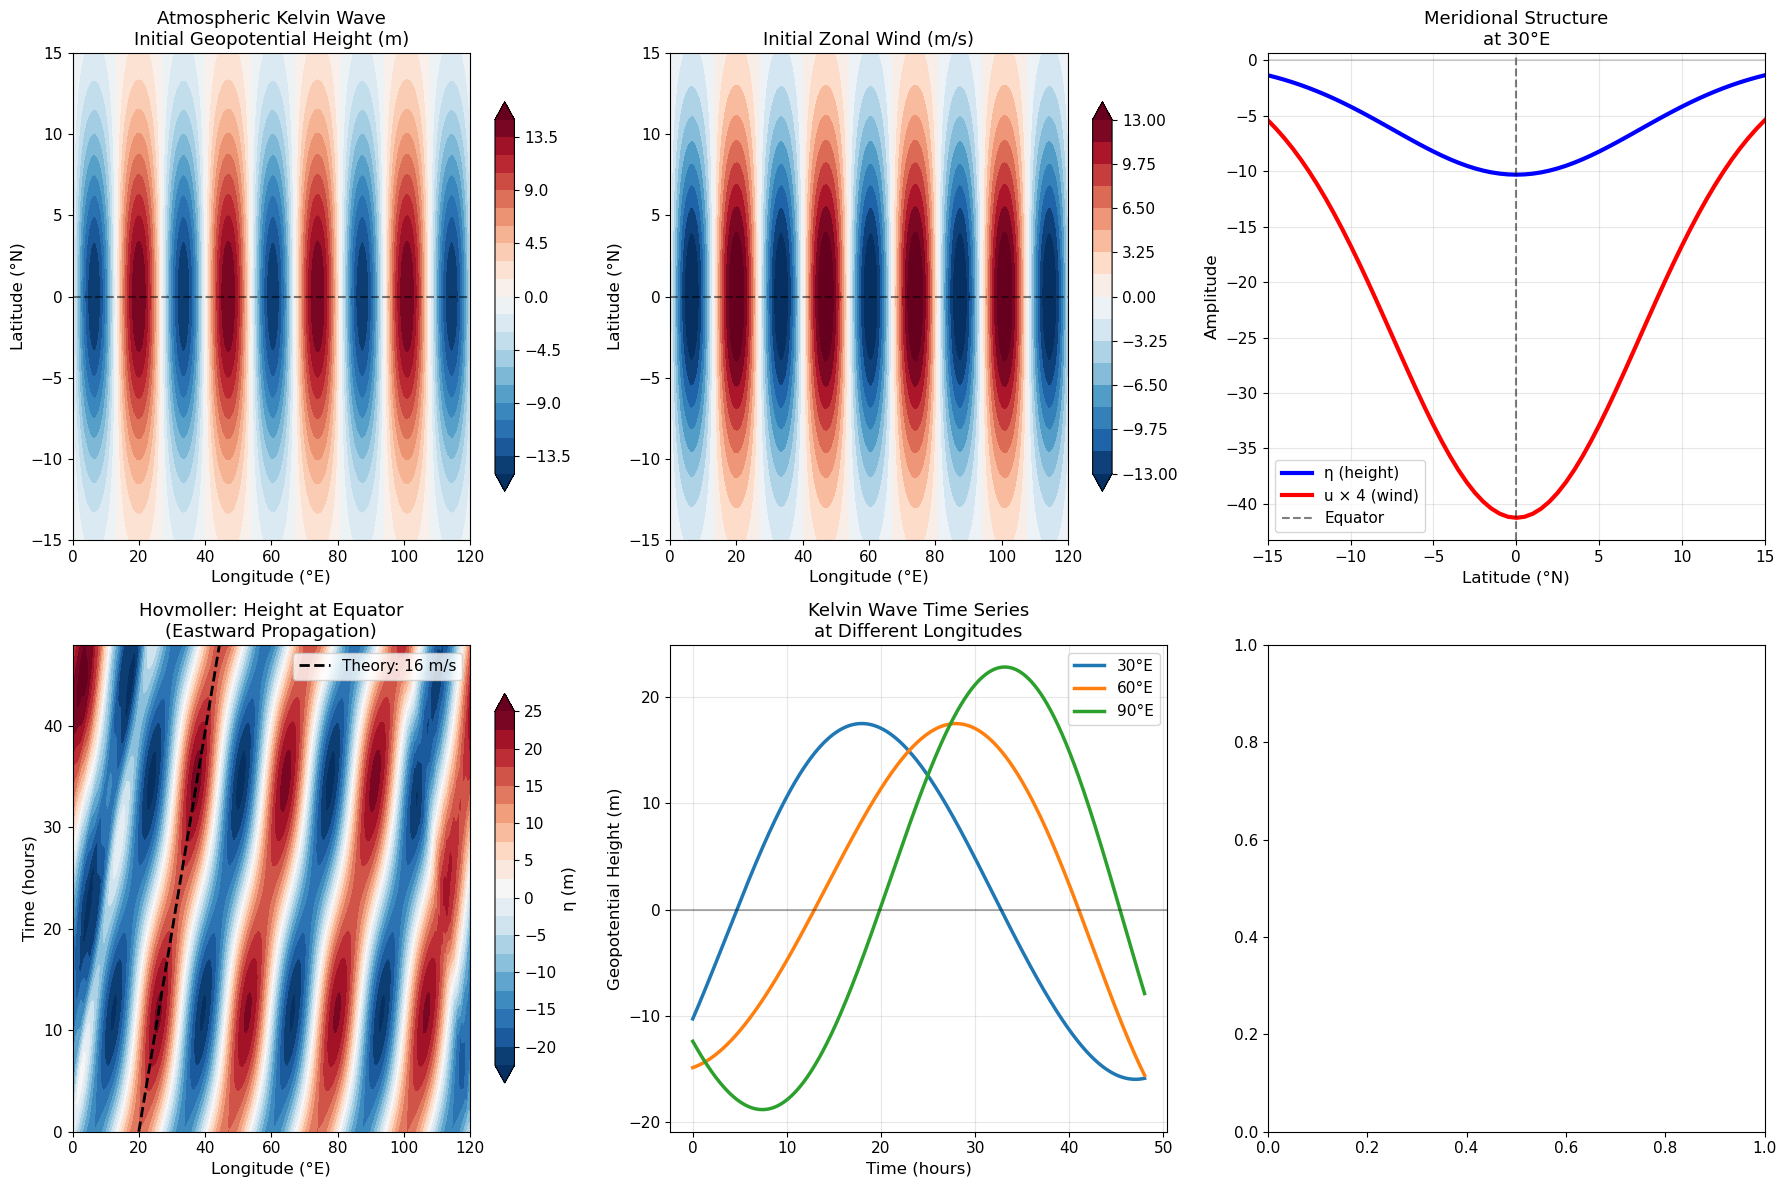

In [22]:
# Initialize atmospheric Kelvin wave
atm_kelvin = atm_model.initialize_kelvin_wave(
    amplitude=15.0,         # 15 m geopotential height perturbation
    wavelength=3000e3,      # 3000 km 
    lon_center=20.0        
)

print("Running atmospheric Kelvin wave simulation...")
atm_kelvin_states = atm_model.integrate(atm_kelvin)
atm_kelvin_ds = atm_model.to_xarray(atm_kelvin_states)
print(f"✓ Simulation complete: {len(atm_kelvin_ds.time)} time steps")

# Kelvin wave analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Initial conditions
im1 = axes[0,0].contourf(atm_model.lon, atm_model.lat, atm_kelvin[2], 
                        levels=np.linspace(-15, 15, 21), cmap='RdBu_r', extend='both')
axes[0,0].set_title('Atmospheric Kelvin Wave\nInitial Geopotential Height (m)')
axes[0,0].set_xlabel('Longitude (°E)')
axes[0,0].set_ylabel('Latitude (°N)')
axes[0,0].axhline(0, color='k', linestyle='--', alpha=0.5)
plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

im2 = axes[0,1].contourf(atm_model.lon, atm_model.lat, atm_kelvin[0], 
                        levels=np.linspace(-13, 13, 17), cmap='RdBu_r', extend='both')
axes[0,1].set_title('Initial Zonal Wind (m/s)')
axes[0,1].set_xlabel('Longitude (°E)')
axes[0,1].set_ylabel('Latitude (°N)')
axes[0,1].axhline(0, color='k', linestyle='--', alpha=0.5)
plt.colorbar(im2, ax=axes[0,1], shrink=0.8)

# Equatorial structure
eq_idx = len(atm_model.lat) // 2
axes[0,2].plot(atm_model.lat, atm_kelvin[2, :, 60], 'b-', linewidth=3, label='η (height)')
axes[0,2].plot(atm_model.lat, atm_kelvin[0, :, 60]*4, 'r-', linewidth=3, label='u × 4 (wind)')
axes[0,2].axvline(0, color='k', linestyle='--', alpha=0.5, label='Equator')
axes[0,2].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[0,2].set_xlabel('Latitude (°N)')
axes[0,2].set_ylabel('Amplitude')
axes[0,2].set_title('Meridional Structure\nat 30°E')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)
axes[0,2].set_xlim(-15, 15)

# Hovmoller diagram
eta_eq = atm_kelvin_ds.eta[:, eq_idx, :]
im3 = axes[1,0].contourf(atm_kelvin_ds.lon, atm_kelvin_ds.time, eta_eq, 
                        levels=21, cmap='RdBu_r', extend='both')
axes[1,0].set_xlabel('Longitude (°E)')
axes[1,0].set_ylabel('Time (hours)')
axes[1,0].set_title('Hovmoller: Height at Equator\n(Eastward Propagation)')
plt.colorbar(im3, ax=axes[1,0], shrink=0.8, label='η (m)')

# Add theoretical speed line
speed_deg_per_hour = atm_model.c * 180 / (np.pi * atm_model.config.earth_radius) * 3600
time_line = np.linspace(0., atm_kelvin_ds.time[-1].values, 100)
lon_theory = 20 + speed_deg_per_hour * time_line
valid_idx = lon_theory <= atm_model.config.lon_max
axes[1,0].plot(lon_theory[valid_idx], time_line[valid_idx], 'k--', linewidth=2, 
              label=f'Theory: {atm_model.c:.0f} m/s')
axes[1,0].legend(loc='upper right')

# Time series at different locations
locations = [30, 60, 90]
for lon_val in locations:
    lon_idx = int((lon_val - atm_model.config.lon_min) / 
                  (atm_model.config.lon_max - atm_model.config.lon_min) * 
                  (atm_model.config.nlon - 1))
    if 0 <= lon_idx < len(atm_model.lon):
        eta_series = atm_kelvin_ds.eta[:, eq_idx, lon_idx]
        axes[1,1].plot(atm_kelvin_ds.time, eta_series, linewidth=2.5, 
                      label=f'{lon_val}°E')

axes[1,1].set_xlabel('Time (hours)')
axes[1,1].set_ylabel('Geopotential Height (m)')
axes[1,1].set_title('Kelvin Wave Time Series\nat Different Longitudes')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Atmospheric Rossby Waves

Atmospheric Rossby waves are important for:
- Tropical cyclone development
- African Easterly Waves
- Westward-propagating disturbances
- Monsoon circulation patterns

Running atmospheric Rossby wave simulation...
✓ Simulation complete


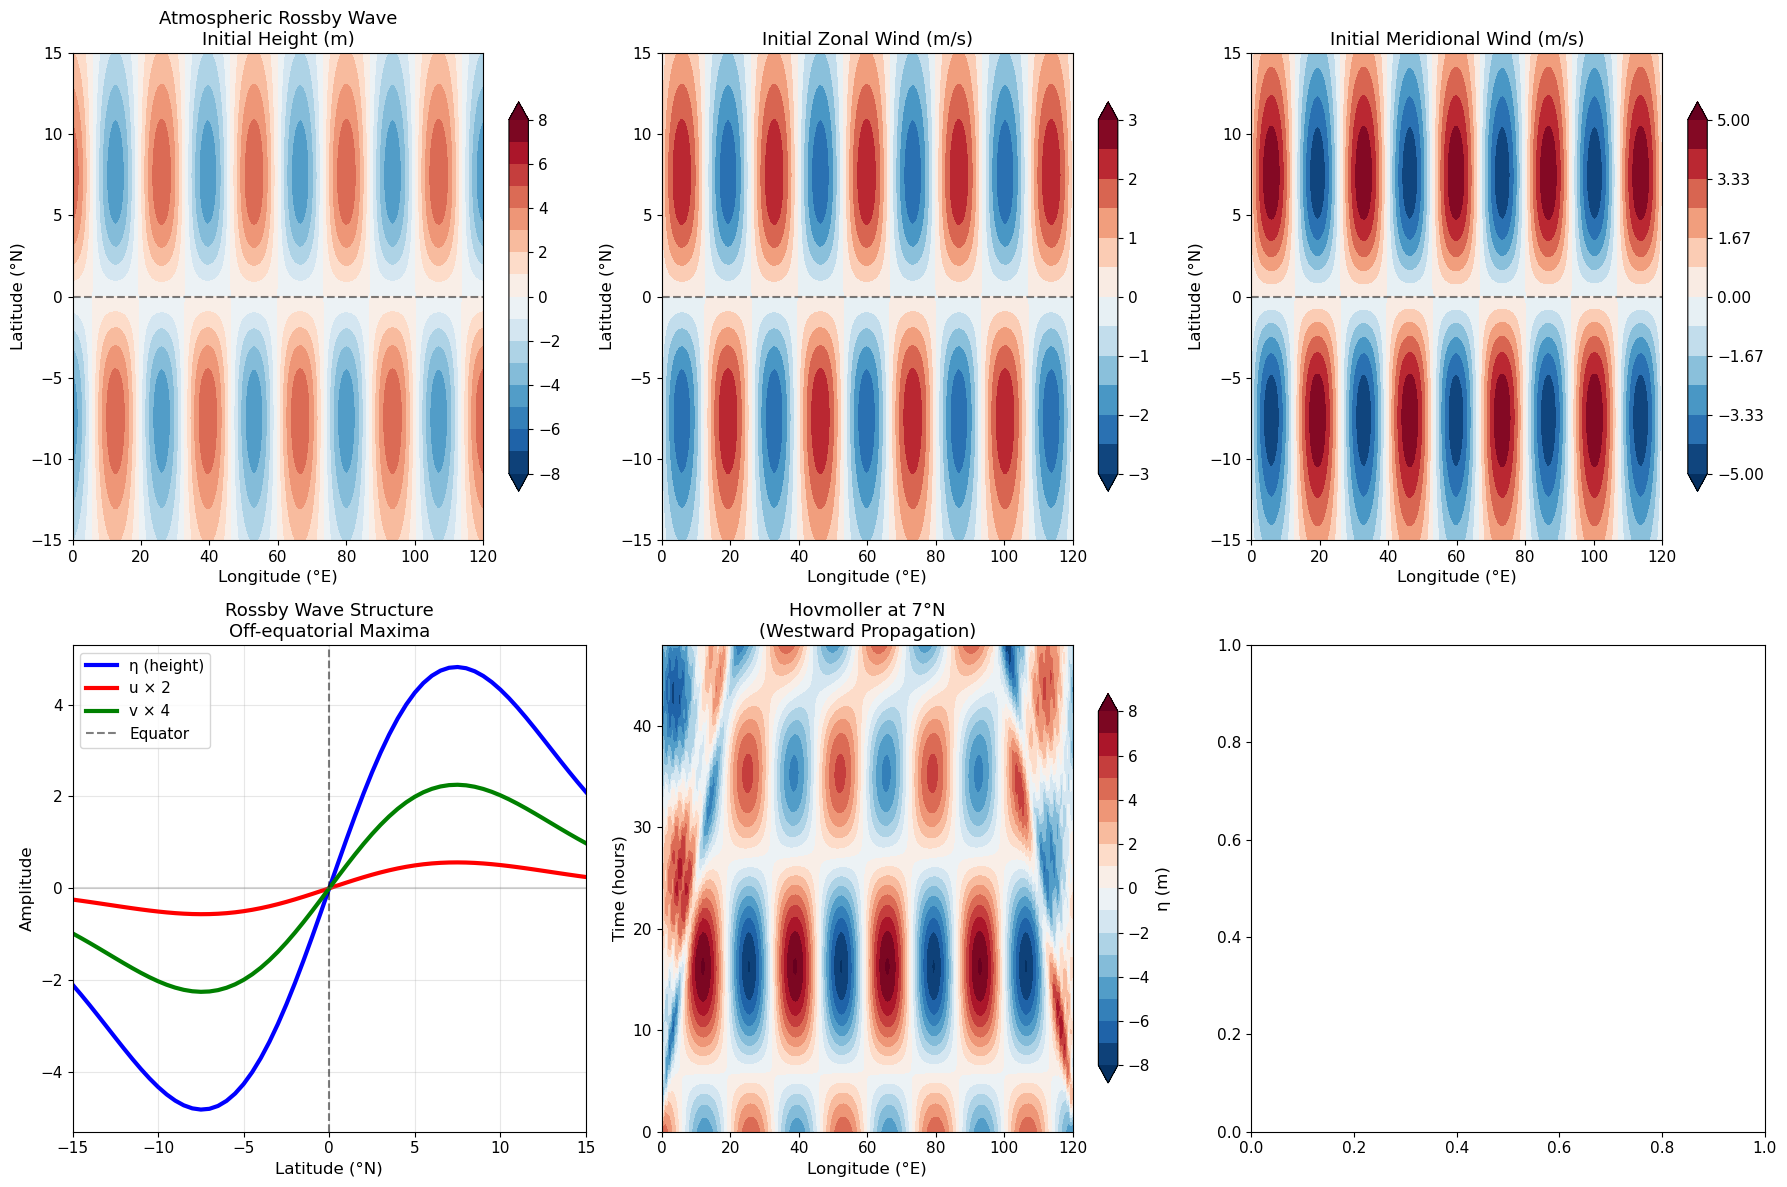

In [39]:
# Initialize atmospheric Rossby wave (n=1 mode)
atm_rossby = atm_model.initialize_rossby_wave(
    amplitude=8.0,          # 8 m amplitude
    wavelength=3000e3,      # 3000 km - typical for tropical waves
    mode=1,                 # First meridional mode
    lon_center=80.0         # Start over Pacific
)

print("Running atmospheric Rossby wave simulation...")
atm_rossby_states = atm_model.integrate(atm_rossby)
atm_rossby_ds = atm_model.to_xarray(atm_rossby_states)
print(f"✓ Simulation complete")

# Rossby wave analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Initial structure
im1 = axes[0,0].contourf(atm_model.lon, atm_model.lat, atm_rossby[2], 
                        levels=np.linspace(-8, 8, 17), cmap='RdBu_r', extend='both')
axes[0,0].set_title('Atmospheric Rossby Wave\nInitial Height (m)')
axes[0,0].set_xlabel('Longitude (°E)')
axes[0,0].set_ylabel('Latitude (°N)')
axes[0,0].axhline(0, color='k', linestyle='--', alpha=0.5)
plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

# Zonal wind
im2 = axes[0,1].contourf(atm_model.lon, atm_model.lat, atm_rossby[0], 
                        levels=np.linspace(-3, 3, 13), cmap='RdBu_r', extend='both')
axes[0,1].set_title('Initial Zonal Wind (m/s)')
axes[0,1].set_xlabel('Longitude (°E)')
axes[0,1].set_ylabel('Latitude (°N)')
axes[0,1].axhline(0, color='k', linestyle='--', alpha=0.5)
plt.colorbar(im2, ax=axes[0,1], shrink=0.8)

# Meridional wind
im3 = axes[0,2].contourf(atm_model.lon, atm_model.lat, atm_rossby[1], 
                        levels=np.linspace(-5, 5, 13), cmap='RdBu_r', extend='both')
axes[0,2].set_title('Initial Meridional Wind (m/s)')
axes[0,2].set_xlabel('Longitude (°E)')
axes[0,2].set_ylabel('Latitude (°N)')
axes[0,2].axhline(0, color='k', linestyle='--', alpha=0.5)
plt.colorbar(im3, ax=axes[0,2], shrink=0.8)

# Meridional structure
lon_idx = int(0.67 * len(atm_model.lon))  # ~80°E
axes[1,0].plot(atm_model.lat, atm_rossby[2, :, lon_idx], 'b-', linewidth=3, label='η (height)')
axes[1,0].plot(atm_model.lat, atm_rossby[0, :, lon_idx]*2, 'r-', linewidth=3, label='u × 2')
axes[1,0].plot(atm_model.lat, atm_rossby[1, :, lon_idx]*4, 'g-', linewidth=3, label='v × 4')
axes[1,0].axvline(0, color='k', linestyle='--', alpha=0.5, label='Equator')
axes[1,0].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1,0].set_xlabel('Latitude (°N)')
axes[1,0].set_ylabel('Amplitude')
axes[1,0].set_title('Rossby Wave Structure\nOff-equatorial Maxima')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim(-15, 15)

# Hovmoller at 7°N (typical for tropical waves)
lat_7n_idx = int((7.0 - atm_model.config.lat_min) / 
                 (atm_model.config.lat_max - atm_model.config.lat_min) * 
                 (atm_model.config.nlat - 1))
eta_7n = atm_rossby_ds.eta[:, lat_7n_idx, :]
im4 = axes[1,1].contourf(atm_rossby_ds.lon, atm_rossby_ds.time, eta_7n, 
                        levels=17, cmap='RdBu_r', extend='both')
axes[1,1].set_xlabel('Longitude (°E)')
axes[1,1].set_ylabel('Time (hours)')
axes[1,1].set_title('Hovmoller at 7°N\n(Westward Propagation)')
plt.colorbar(im4, ax=axes[1,1], shrink=0.8, label='η (m)')

plt.tight_layout()
plt.show()

## 4. Convective Coupling Simulation

Simulate a tropical convective disturbance that excites both Kelvin and Rossby wave modes.
This represents realistic atmospheric conditions where convection acts as a wave source.

Running convectively coupled wave simulation...
✓ Simulation complete


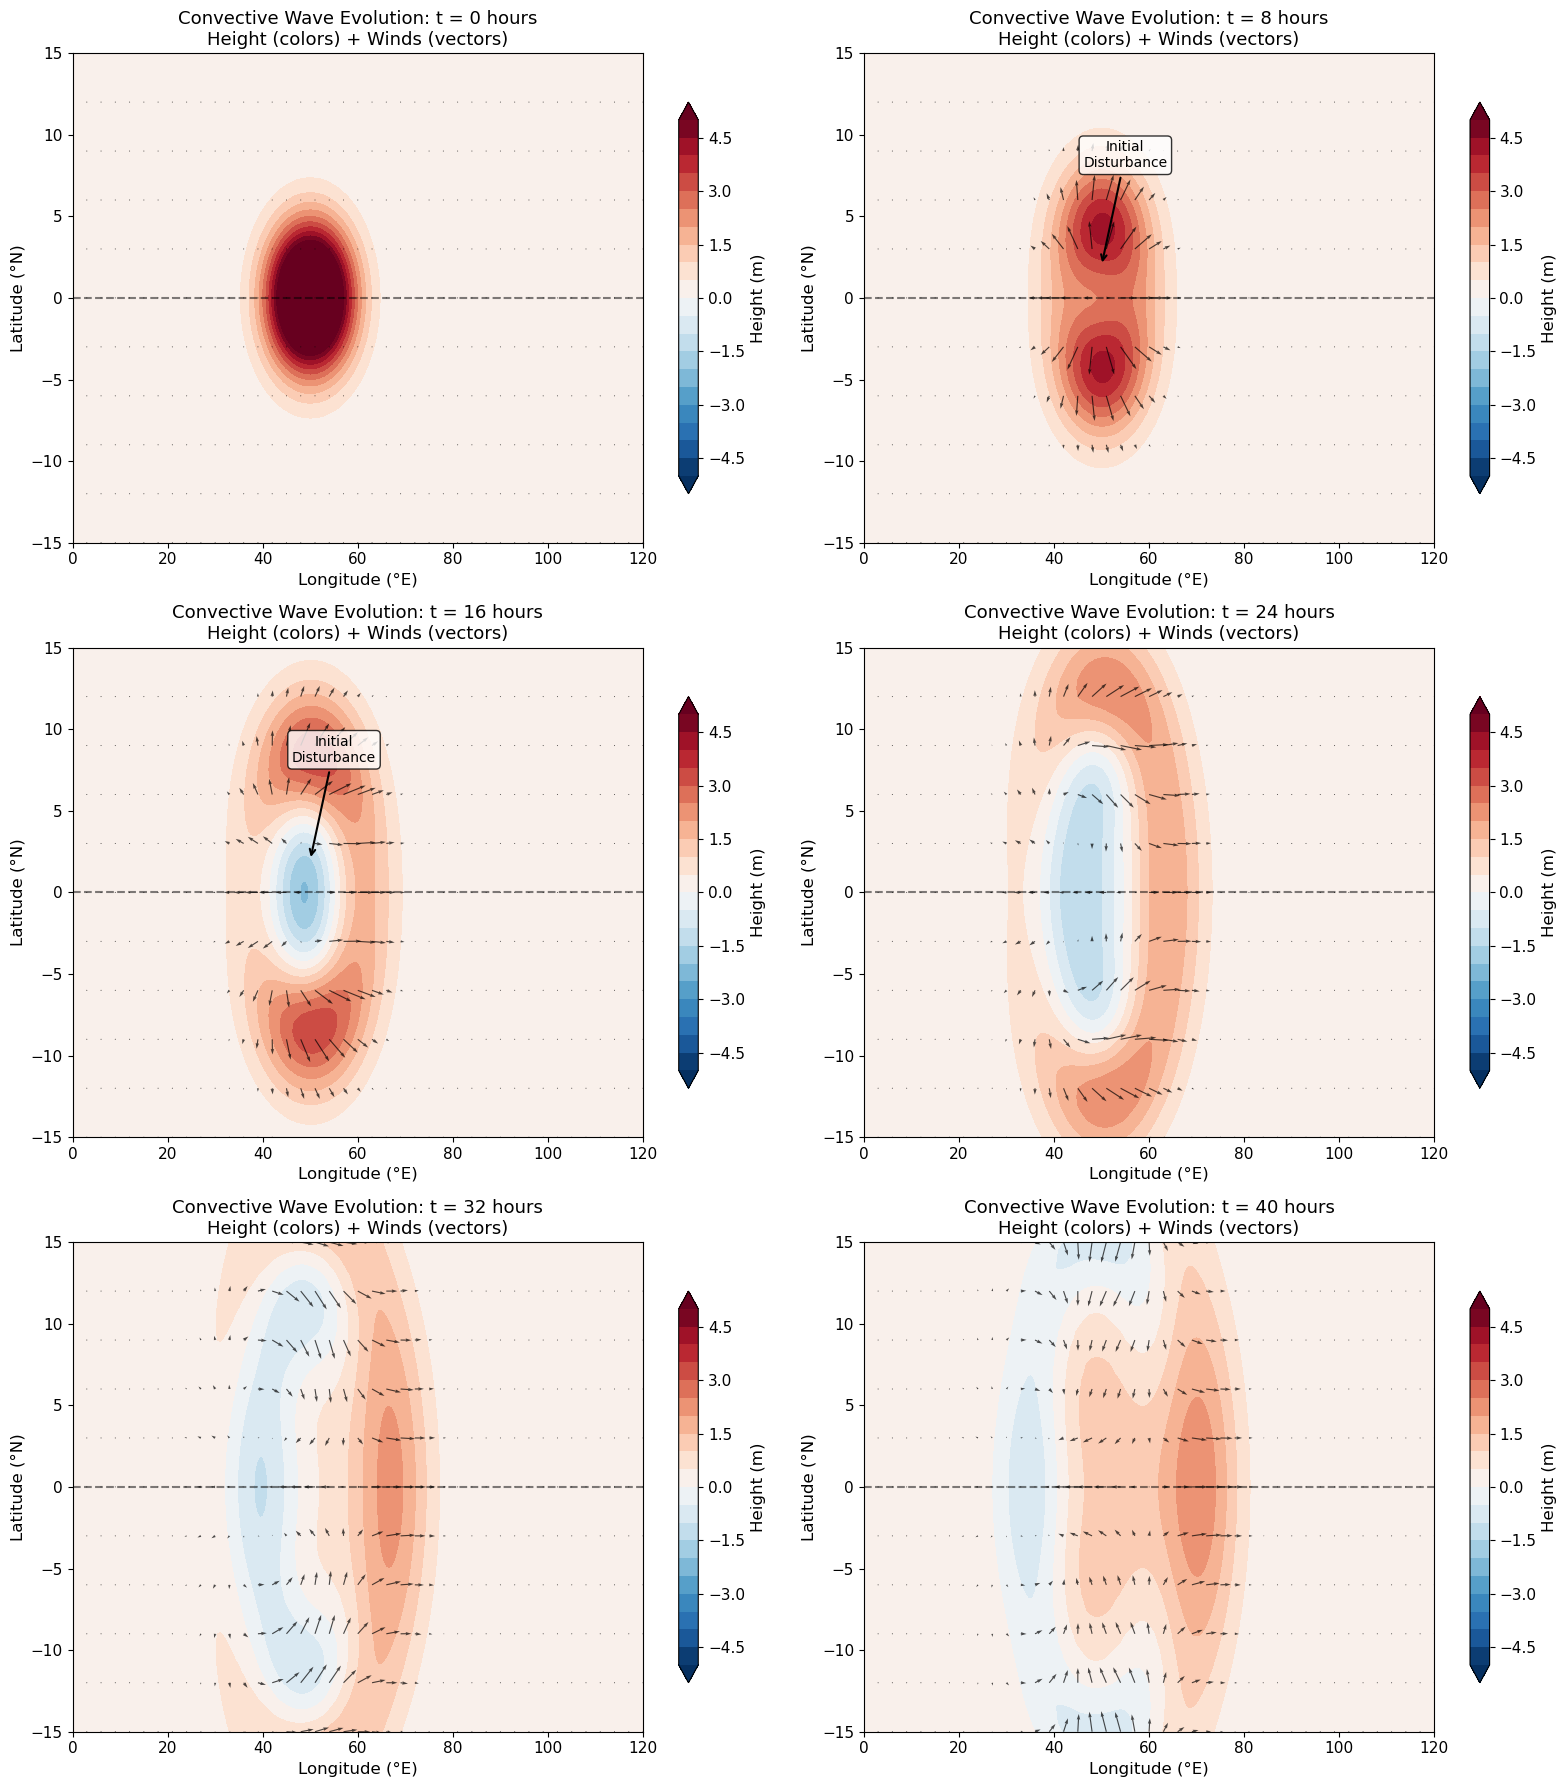


=== CONVECTIVELY COUPLED WAVE ANALYSIS ===
Initial perturbation: Localized convective heating analogue
Wave decomposition: Simultaneous Kelvin and Rossby wave generation
Kelvin component: Eastward propagation at ~16 m/s
Rossby component: Westward propagation at ~1.6 m/s


In [37]:
# Create a convective heating-like perturbation
amplitude = 10.0
atm_convection = atm_model.initialize_gaussian_perturbation(
    amplitude=amplitude,         # 12 m - strong convective signal
    lon_center=50.0,        # Centered at 50°E
    lat_center=0.0,         # At equator
    sigma_lon=6.0,          # 6° longitude spread (localized convection)
    sigma_lat=3.0           # 3° latitude spread
)

print("Running convectively coupled wave simulation...")
atm_conv_states = atm_model.integrate(atm_convection)
atm_conv_ds = atm_model.to_xarray(atm_conv_states)
print(f"✓ Simulation complete")

# Show wave decomposition evolution
time_indices = [0, 120, 240, 360, 480, 600]  # 0, 8, 16, 24, 32, 40 hours
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, t_idx in enumerate(time_indices):
    if t_idx < len(atm_conv_ds.time):
        time_hours = atm_conv_ds.time[t_idx].values
        
        # Plot height field
        vmax = 0.5*amplitude
        im = axes[i].contourf(atm_conv_ds.lon, atm_conv_ds.lat, 
                             atm_conv_ds.eta[t_idx], 
                             levels=np.linspace(-vmax, vmax, 21), 
                             cmap='RdBu_r', extend='both')
        
        # Add wind vectors
        skip = 6
        wind_scale = 50
        axes[i].quiver(atm_conv_ds.lon[::skip], atm_conv_ds.lat[::skip],
                      atm_conv_ds.u[t_idx, ::skip, ::skip], 
                      atm_conv_ds.v[t_idx, ::skip, ::skip],
                      scale=wind_scale, alpha=0.7, width=0.002)
        
        axes[i].set_title(f'Convective Wave Evolution: t = {time_hours:.0f} hours\nHeight (colors) + Winds (vectors)')
        axes[i].set_xlabel('Longitude (°E)')
        axes[i].set_ylabel('Latitude (°N)')
        axes[i].axhline(0, color='k', linestyle='--', alpha=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.8)
        cbar.set_label('Height (m)')
        
        # Add annotations for wave identification
        if time_hours > 0:
            if time_hours <= 16:
                axes[i].annotate('Initial\nDisturbance', xy=(50, 2), xytext=(55, 8),
                               arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                               fontsize=10, ha='center', 
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Analyze wave separation
print(f"\n=== CONVECTIVELY COUPLED WAVE ANALYSIS ===")
print(f"Initial perturbation: Localized convective heating analogue")
print(f"Wave decomposition: Simultaneous Kelvin and Rossby wave generation")
print(f"Kelvin component: Eastward propagation at ~{atm_model.c:.0f} m/s")
print(f"Rossby component: Westward propagation at ~{atm_model.c/10:.1f} m/s")


## 5. Atmospheric Time Scale Analysis

Examine the relevant time scales for atmospheric equatorial waves and their meteorological significance.

=== ATMOSPHERIC WAVE MODES COMPARISON ===
Mode            H (m)    c (m/s)    L_eq (km)    Period* (days) 
----------------------------------------------------------------------
2nd baroclinic  12       10.8       688          3.2            
1st baroclinic  25       15.7       827          2.2            
Mixed mode      50       22.1       984          1.6            
Barotropic-like 100      31.3       1170         1.1            


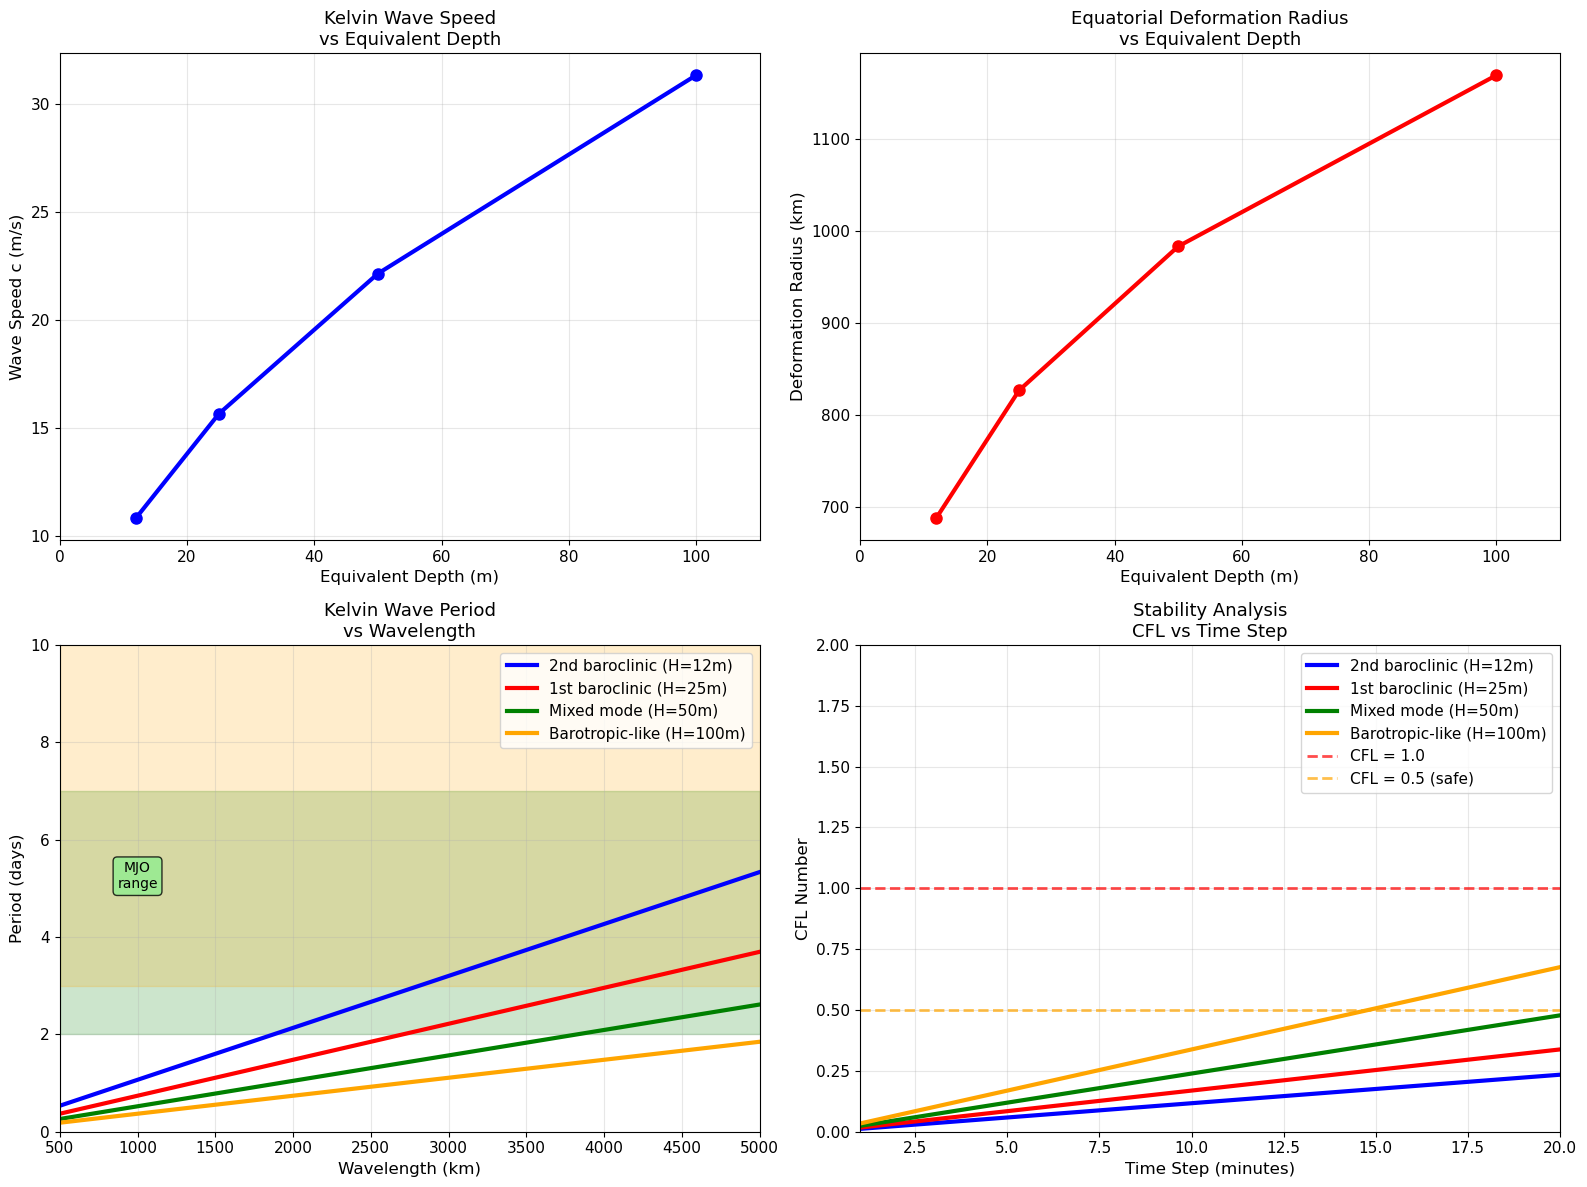


*Period calculated for 3000 km wavelength

=== METEOROLOGICAL APPLICATIONS ===
• 1st baroclinic mode (H=25m): Large scale dynamics
• 2nd baroclinic mode (H=12m): High-frequency convective coupling
• Mixed modes (H=50m): Monsoon intraseasonal variability
• Higher modes: Barotropic planetary waves, seasonal cycles


In [40]:
# Compare different equivalent depths (atmospheric modes)
equivalent_depths = [12, 25, 50, 100]  # meters
mode_names = ['2nd baroclinic', '1st baroclinic', 'Mixed mode', 'Barotropic-like']
colors = ['blue', 'red', 'green', 'orange']

print("=== ATMOSPHERIC WAVE MODES COMPARISON ===")
print(f"{'Mode':<15} {'H (m)':<8} {'c (m/s)':<10} {'L_eq (km)':<12} {'Period* (days)':<15}")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wave speed vs equivalent depth
wave_speeds = [np.sqrt(9.81 * h) for h in equivalent_depths]
deformation_radii = [np.sqrt(c / (2 * 7.292e-5 / 6.371e6)) / 1000 for c in wave_speeds]
periods = [3000e3 / c / 86400 for c in wave_speeds]  # 3000 km wavelength period in days

for i, (h, mode, c, L, T) in enumerate(zip(equivalent_depths, mode_names, wave_speeds, deformation_radii, periods)):
    print(f"{mode:<15} {h:<8} {c:<10.1f} {L:<12.0f} {T:<15.1f}")

axes[0,0].plot(equivalent_depths, wave_speeds, 'o-', linewidth=3, markersize=8, color='blue')
axes[0,0].set_xlabel('Equivalent Depth (m)')
axes[0,0].set_ylabel('Wave Speed c (m/s)')
axes[0,0].set_title('Kelvin Wave Speed\nvs Equivalent Depth')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xlim(0, 110)

axes[0,1].plot(equivalent_depths, deformation_radii, 'o-', linewidth=3, markersize=8, color='red')
axes[0,1].set_xlabel('Equivalent Depth (m)')
axes[0,1].set_ylabel('Deformation Radius (km)')
axes[0,1].set_title('Equatorial Deformation Radius\nvs Equivalent Depth')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlim(0, 110)

# Period vs wavelength for different modes
wavelengths = np.linspace(500e3, 5000e3, 50)  # 500-5000 km
for i, (h, mode, color) in enumerate(zip(equivalent_depths, mode_names, colors)):
    c = np.sqrt(9.81 * h)
    periods_days = wavelengths / c / 86400
    axes[1,0].plot(wavelengths/1000, periods_days, linewidth=3, color=color, label=f'{mode} (H={h}m)')

axes[1,0].set_xlabel('Wavelength (km)')
axes[1,0].set_ylabel('Period (days)')
axes[1,0].set_title('Kelvin Wave Period\nvs Wavelength')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim(500, 5000)
axes[1,0].set_ylim(0, 10)

# Add meteorological phenomena ranges
axes[1,0].axhspan(2, 7, alpha=0.2, color='green', label='MJO range')
axes[1,0].axhspan(3, 20, alpha=0.2, color='orange', label='Seasonal cycle')
axes[1,0].text(1000, 5, 'MJO\nrange', fontsize=10, ha='center', 
              bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Stability diagram
dt_minutes = np.linspace(1, 20, 50)
for i, (h, mode, color) in enumerate(zip(equivalent_depths, mode_names, colors)):
    c = np.sqrt(9.81 * h)
    dx = 120 * np.pi/180 * 6.371e6 / 240  # Grid spacing
    cfl_numbers = c * (dt_minutes * 60) / dx
    axes[1,1].plot(dt_minutes, cfl_numbers, linewidth=3, color=color, label=f'{mode} (H={h}m)')

axes[1,1].axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='CFL = 1.0')
axes[1,1].axhline(0.5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='CFL = 0.5 (safe)')
axes[1,1].set_xlabel('Time Step (minutes)')
axes[1,1].set_ylabel('CFL Number')
axes[1,1].set_title('Stability Analysis\nCFL vs Time Step')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim(1, 20)
axes[1,1].set_ylim(0, 2)

plt.tight_layout()
plt.show()

print(f"\n*Period calculated for 3000 km wavelength")
print(f"\n=== METEOROLOGICAL APPLICATIONS ===")
print(f"• 1st baroclinic mode (H=25m): Large scale dynamics")
print(f"• 2nd baroclinic mode (H=12m): High-frequency convective coupling")
print(f"• Mixed modes (H=50m): Monsoon intraseasonal variability")
print(f"• Higher modes: Barotropic planetary waves, seasonal cycles")